In [1]:
import json
import numpy as np
import pandas as pd
import plotly.express as px

In [2]:
with open("results.json") as in_file:
    data = json.loads(in_file.read())

In [3]:
records = []
for subject in data:
    for i, (tau, p) in enumerate(zip(data[subject]["tau"], data[subject]["p"])):
        records.append(dict(subject=subject, timestamp=(i-200)/1000, tau=tau, p=p, model="lr"))

In [4]:
df = pd.DataFrame.from_records(records)

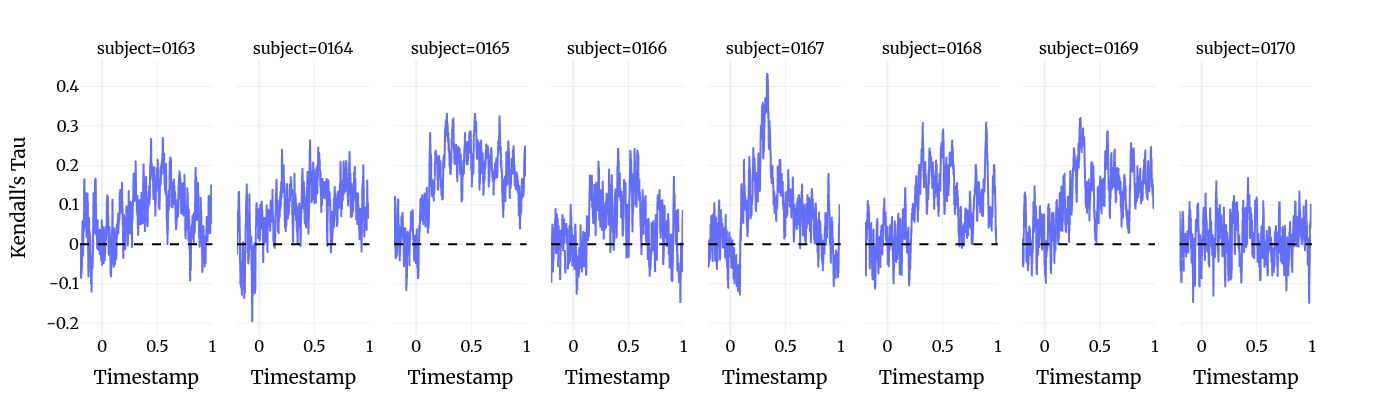

In [7]:
fig = px.line(df, x="timestamp", y="tau", color="model", facet_col="subject")
fig = fig.update_traces(showlegend=False)
fig = fig.update_layout(
    template="plotly_white",
    yaxis_title="Kendall's Tau",
    width=1400,
    height=400,
    font=dict(family="Merriweather", size=16, color="black"),
)
fig = fig.update_xaxes(title="Timestamp")
fig = fig.add_hline(y=0, line=dict(color="black", dash="dash"))
fig.show()

In [8]:
from scipy.stats import combine_pvalues, false_discovery_control

pvalues = []
for subject in data:
    p = np.array(data[subject]["p"])[:, 1]
    pvalues.append(p)
pvalues = np.stack(pvalues)
# Combining p-values from all participants in each timestamp
combined_p = combine_pvalues(pvalues, axis=0, nan_policy="omit").pvalue
# Controlling for false discovery
controlled_p = false_discovery_control(combined_p, method="by")

In [9]:
alpha_level = 0.05
significant_periods = np.where(np.diff(controlled_p < alpha_level))[0]
if len(significant_periods) % 2:
    significant_periods = np.append(significant_periods, 1201)
significant_periods = significant_periods.reshape(-1, 2)
significant_periods = (significant_periods - 200)/1000

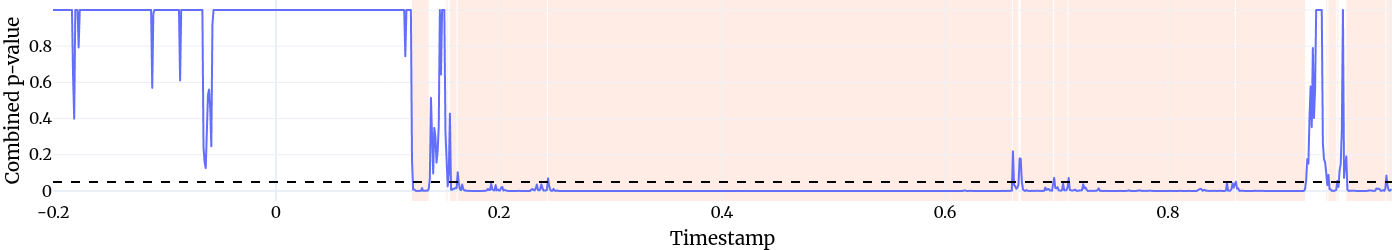

In [12]:
timestamps = (np.arange(1201)-200)/1000
fig = px.line(x=timestamps,y=controlled_p)
fig = fig.update_traces(showlegend=False,) #line=dict(color="grey"))
fig = fig.update_layout(
    template="plotly_white",
    yaxis_title="Combined p-value", 
    xaxis_title="Timestamp",
    width=1200,
    height=250,
    font=dict(family="Merriweather", size=16, color="black"),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig = fig.add_hline(y=alpha_level, line=dict(color="black", dash="dash"))
for x0, x1 in significant_periods:
    #if (x1 - x0) > 0.01:
        fig.add_vrect(
            x0=x0, x1=x1,
            fillcolor="LightSalmon", opacity=0.2,
            layer="below", line_width=0,
        )
fig.show()

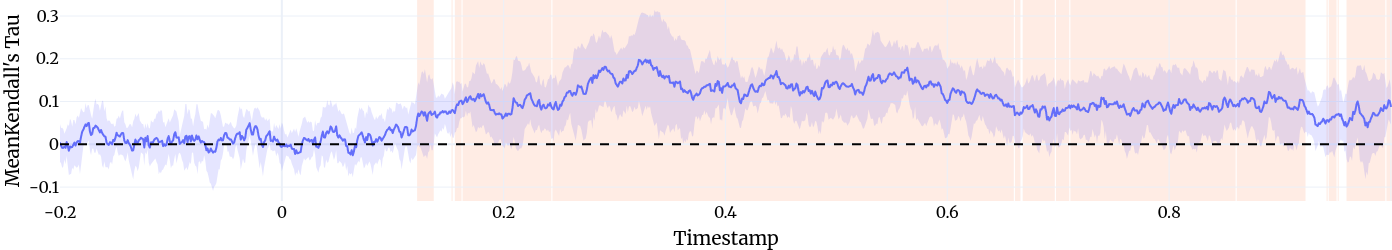

In [14]:
taus = []
for subject in data:
    tau = np.array(data[subject]["tau"])
    taus.append(tau)
taus = np.stack(taus)
m_tau = np.nanmean(taus, axis=0)
std_tau = np.nanstd(taus, axis=0)
fig = px.line(x=timestamps,y=m_tau)
fig = fig.add_scatter(
    name='Upper Bound',
    x=timestamps,
    y=m_tau+std_tau,
    mode='lines',
    line=dict(width=0),
    showlegend=False
)
fig = fig.add_scatter(
    name='Lower Bound',
    x=timestamps,
    y=m_tau-std_tau,
    line=dict(width=0),
    mode='lines',
    fillcolor='rgba(0, 0, 255, 0.1)',
    fill='tonexty',
    showlegend=False
)
fig = fig.update_traces(showlegend=False,) #line=dict(color="grey"))
fig = fig.update_layout(
    template="plotly_white",
    yaxis_title="MeanKendall's Tau", 
    xaxis_title="Timestamp",
    width=1200,
    height=250,
    font=dict(family="Merriweather", size=16, color="black"),
    margin=dict(l=0, r=0, t=0, b=0),
)
fig = fig.add_hline(y=0, line=dict(color="black", dash="dash"))
for x0, x1 in significant_periods:
    #if (x1 - x0) > 0.01:
        fig.add_vrect(
            x0=x0, x1=x1,
            fillcolor="LightSalmon", opacity=0.2,
            layer="below", line_width=0,
        )
fig.show()